This Main jupyter file is where the training of the main models occur. This is done with references to the MONAI tutorial on 3d_segmentation

    1)Transforms for dictionary format data.
    2)Define a new transform according to MONAI transform API.
    3)Load NRRD image with metadata, load a list of images and stack them.
    4)Randomly adjust intensity for data augmentation.
    5)Cache IO and transforms to accelerate training and validation.
    6)3D UNETR model, DiceCE loss function, Mean Dice metric and HausdorffDistanceMetric
    7)Saves all the loss graph plot and dice plot
    8)Saves plot of final predicted label vs baseline label
    
    


[1]: Hatamizadeh, A., Tang, Y., Nath, V., Yang, D., Myronenko, A., Landman, B., Roth, H.R. and Xu, D., 2022. Unetr: Transformers for 3d medical image segmentation. In Proceedings of the IEEE/CVF Winter Conference on Applications of Computer Vision (pp. 574-584).

In [1]:
import os
import shutil
import tempfile
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm

import nrrd

import numpy as np
import SimpleITK as sitk

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized,
    SaveImage,
)
from monai.config import print_config
from monai.metrics import DiceMetric

from monai.networks.nets import SegResNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
print_config()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.21.0
scipy version: 1.8.0
Pillow version: 9.0.1
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.3.5
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory (For saving and loading of data)
## If not specified a temporary directory will be used.

In [2]:
directory = '/home/katan/'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/katan/


## Setup Transformer


In [3]:
train_transforms = Compose(
    [

        # Loads images and corresponding labels from the specified keys.
        LoadImaged(keys=["image", "label"]),
                         
        #Ensures that the channel dimension is the first dimension in both the image and label arrays.
        EnsureChannelFirstd(keys=["image", "label"]),
        #Reshapes the image and label arrays according to the provided orientation codes ("RAS" in this case),
        #ensuring consistent orientation across different images.
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        #’RAS’ represents 3D orientation: (Left, Right), (Posterior, Anterior), (Inferior, Superior).
          Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 1.0),  # Adjusted for the new volume sizes
            mode=("bilinear", "nearest"),
        ),
        
        #Scales the intensity values of the images within a specified range (a_min to a_max) to a new range (b_min to b_max). 
        #It's commonly used for normalization.
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        #Crops the foreground (non-zero intensity regions) of the images and corresponding labels.
        #It uses the source key "image" to determine the foreground region.
        #good when the valid part is small in the image
        CropForegroundd(keys=["image", "label"], source_key="image"),


        #Performs random cropping based on positive and negative labels. 
        #It selects random spatial locations based on the specified spatial size and the number of positive and negative samples.
                         
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        #Randomly flips the images and labels along the specified spatial axis with a given probability.
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        # Randomly rotates the images and labels by 90 degrees multiples, with a specified probability (prob) and maximum number of rotations (max_k=3).
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        # Randomly shifts the intensity values of the images within a specified offset range (offsets) with a given probability.
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 0),  # Adjusted for the new volume sizes
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


# Set up data directory

In [4]:
data_dir = '/home/katan/Dataset/'
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=32,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=8, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)


Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:48<00:00,  6.06s/it]


# Check data shape and visualize


image shape: torch.Size([1, 135, 131, 224]), label shape: torch.Size([1, 135, 131, 224])


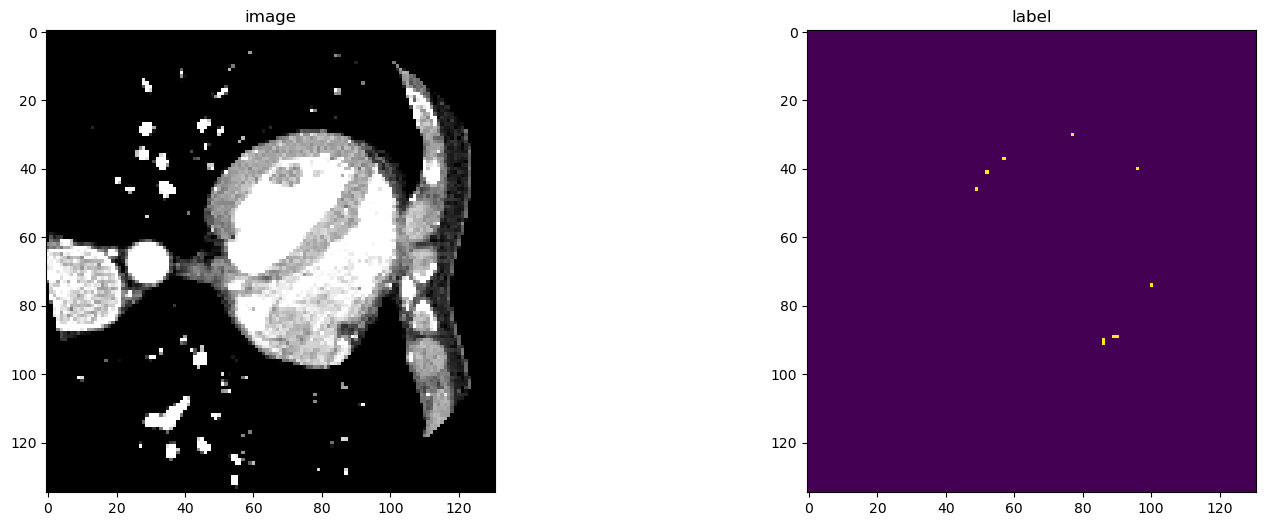

In [5]:
slice_map = {
    "Diseased_1.nrrd": 45,
    "Diseased_2.nrrd": 23,
    "Diseased_17.nrrd": 112,
    "Normal_1.nrrd": 79,
    "Normal_4.nrrd": 23,
    "Normal_6.nrrd": 64,
    
}
case_num = 0

#Validation Set
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
# Save the plot
plt.savefig('plot0_25k.png') 
plt.show()



# Create Model, Loss, Optimizer



In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=14,
    dropout_prob=0.2,
).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


# Training Functions

In [9]:

def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()

    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "SegResNet.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


# PyTorch training process


In [15]:


max_iterations = 10000 #change this accordingly
eval_num = 250 #change this accordingly
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "SegResNet.pth")))

Training (251 / 10000 Steps) (loss=2.34690):  88%|████████████████████████████████████████████████████████████████████████████████████▉            | 28/32 [00:07<00:02,  1.40it/s]

Model Was Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (501 / 10000 Steps) (loss=2.02212):  69%|██████████████████████████████████████████████████████████████████▋                              | 22/32 [00:04<00:04,  2.38it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (751 / 10000 Steps) (loss=1.74401):  50%|████████████████████████████████████████████████▌                                                | 16/32 [00:04<00:06,  2.35it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (1001 / 10000 Steps) (loss=1.52534):  31%|██████████████████████████████                                                                  | 10/32 [00:03<00:08,  2.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (1251 / 10000 Steps) (loss=1.36237):  12%|████████████▏                                                                                    | 4/32 [00:01<00:13,  2.08it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (1501 / 10000 Steps) (loss=1.24594):  94%|██████████████████████████████████████████████████████████████████████████████████████████      | 30/32 [00:05<00:00,  2.80it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (1751 / 10000 Steps) (loss=1.16470):  75%|████████████████████████████████████████████████████████████████████████                        | 24/32 [00:05<00:03,  2.03it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (2000 / 10000 Steps) (loss=1.10747):  53%|███████████████████████████████████████████████████                                             | 17/32 [00:04<00:07,  2.11it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (2251 / 10000 Steps) (loss=1.06889):  38%|████████████████████████████████████                                                            | 12/32 [00:03<00:07,  2.52it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (2501 / 10000 Steps) (loss=1.03890):  19%|██████████████████▏                                                                              | 6/32 [00:02<00:11,  2.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (2751 / 10000 Steps) (loss=1.01712): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  2.49it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (3000 / 10000 Steps) (loss=0.99848):  78%|███████████████████████████████████████████████████████████████████████████                     | 25/32 [00:05<00:03,  2.01it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.4998551607131958 Current Avg. Dice: 0.4998551607131958


Training (3251 / 10000 Steps) (loss=0.98691):  62%|████████████████████████████████████████████████████████████                                    | 20/32 [00:06<00:09,  1.32it/s]

Model Was Saved ! Current Best Avg. Dice: 0.5825052261352539 Current Avg. Dice: 0.5825052261352539


Training (3501 / 10000 Steps) (loss=0.96294):  44%|██████████████████████████████████████████                                                      | 14/32 [00:05<00:12,  1.39it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8126457929611206 Current Avg. Dice: 0.8126457929611206


Training (3751 / 10000 Steps) (loss=0.94578):  25%|████████████████████████▎                                                                        | 8/32 [00:04<00:18,  1.31it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8201966285705566 Current Avg. Dice: 0.8201966285705566


Training (4001 / 10000 Steps) (loss=0.92680):   6%|██████                                                                                           | 2/32 [00:03<00:41,  1.38s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8413541316986084 Current Avg. Dice: 0.8413541316986084


Training (4251 / 10000 Steps) (loss=0.91717):  88%|████████████████████████████████████████████████████████████████████████████████████            | 28/32 [00:07<00:02,  1.40it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8549948930740356 Current Avg. Dice: 0.8549948930740356


Training (4501 / 10000 Steps) (loss=0.91345):  69%|██████████████████████████████████████████████████████████████████                              | 22/32 [00:04<00:03,  2.76it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8549948930740356 Current Avg. Dice: 0.8522905707359314


Training (4751 / 10000 Steps) (loss=0.90028):  50%|████████████████████████████████████████████████                                                | 16/32 [00:05<00:11,  1.40it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8640553951263428 Current Avg. Dice: 0.8640553951263428


Training (5000 / 10000 Steps) (loss=0.89379):  28%|███████████████████████████▎                                                                     | 9/32 [00:04<00:24,  1.07s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8676565289497375 Current Avg. Dice: 0.8676565289497375


Training (5251 / 10000 Steps) (loss=0.88352):  12%|████████████▏                                                                                    | 4/32 [00:02<00:14,  1.94it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8676565289497375 Current Avg. Dice: 0.8629140853881836


Training (5501 / 10000 Steps) (loss=0.89085):  94%|██████████████████████████████████████████████████████████████████████████████████████████      | 30/32 [00:07<00:01,  1.41it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8859876394271851 Current Avg. Dice: 0.8859876394271851


Training (5751 / 10000 Steps) (loss=0.88348):  75%|████████████████████████████████████████████████████████████████████████                        | 24/32 [00:05<00:03,  2.54it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8859876394271851 Current Avg. Dice: 0.8817406892776489


Training (6001 / 10000 Steps) (loss=0.88408):  56%|██████████████████████████████████████████████████████                                          | 18/32 [00:04<00:05,  2.51it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8859876394271851 Current Avg. Dice: 0.8562471866607666


Training (6251 / 10000 Steps) (loss=0.88164):  38%|████████████████████████████████████                                                            | 12/32 [00:03<00:07,  2.53it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8859876394271851 Current Avg. Dice: 0.8811722993850708


Training (6501 / 10000 Steps) (loss=0.87263):  19%|██████████████████▏                                                                              | 6/32 [00:02<00:10,  2.39it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8859876394271851 Current Avg. Dice: 0.8778350353240967


Training (6751 / 10000 Steps) (loss=0.87458): 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  1.44it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8960341215133667


Training (7001 / 10000 Steps) (loss=0.87661):  81%|██████████████████████████████████████████████████████████████████████████████                  | 26/32 [00:05<00:02,  2.61it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8828586339950562


Training (7251 / 10000 Steps) (loss=0.87208):  62%|████████████████████████████████████████████████████████████                                    | 20/32 [00:04<00:04,  2.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8870745301246643


Training (7501 / 10000 Steps) (loss=0.87136):  44%|██████████████████████████████████████████                                                      | 14/32 [00:03<00:06,  2.82it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8871469497680664


Training (7751 / 10000 Steps) (loss=0.87745):  25%|████████████████████████▎                                                                        | 8/32 [00:02<00:09,  2.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8760639429092407


Training (8001 / 10000 Steps) (loss=0.87325):   6%|██████                                                                                           | 2/32 [00:01<00:22,  1.36it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8834996223449707


Training (8251 / 10000 Steps) (loss=0.86921):  88%|████████████████████████████████████████████████████████████████████████████████████            | 28/32 [00:06<00:01,  2.48it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8936347961425781


Training (8501 / 10000 Steps) (loss=0.86918):  69%|██████████████████████████████████████████████████████████████████                              | 22/32 [00:04<00:03,  2.67it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8911536335945129


Training (8751 / 10000 Steps) (loss=0.87156):  50%|████████████████████████████████████████████████                                                | 16/32 [00:04<00:05,  2.77it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8892982006072998


Training (9001 / 10000 Steps) (loss=0.86849):  31%|██████████████████████████████                                                                  | 10/32 [00:03<00:08,  2.47it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8930918574333191


Training (9251 / 10000 Steps) (loss=0.87383):  12%|████████████▏                                                                                    | 4/32 [00:01<00:13,  2.09it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8749870657920837


Training (9501 / 10000 Steps) (loss=0.87386):  94%|██████████████████████████████████████████████████████████████████████████████████████████      | 30/32 [00:06<00:00,  2.62it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8795427083969116


Training (9751 / 10000 Steps) (loss=0.86923):  75%|████████████████████████████████████████████████████████████████████████                        | 24/32 [00:05<00:02,  2.78it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8893673419952393


Training (10001 / 10000 Steps) (loss=0.87145):  56%|█████████████████████████████████████████████████████▍                                         | 18/32 [00:04<00:04,  2.82it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.8960341215133667 Current Avg. Dice: 0.8806915283203125


Training (10015 / 10000 Steps) (loss=0.86758): 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.88it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/katan/SegResNet.pth'

In [16]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")


train completed, best_metric: 0.8960 at iteration: 6750


# Plot the loss and metric


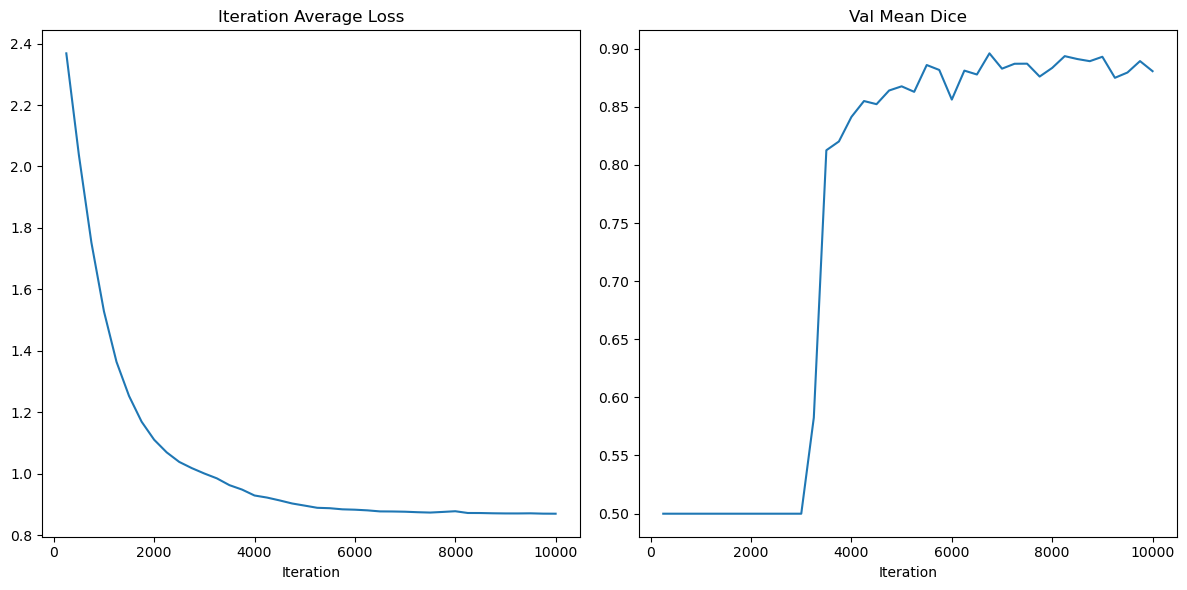

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Save the plot
plt.savefig('plot_25k.png') 

plt.show()

# Check best model output with the input image and label


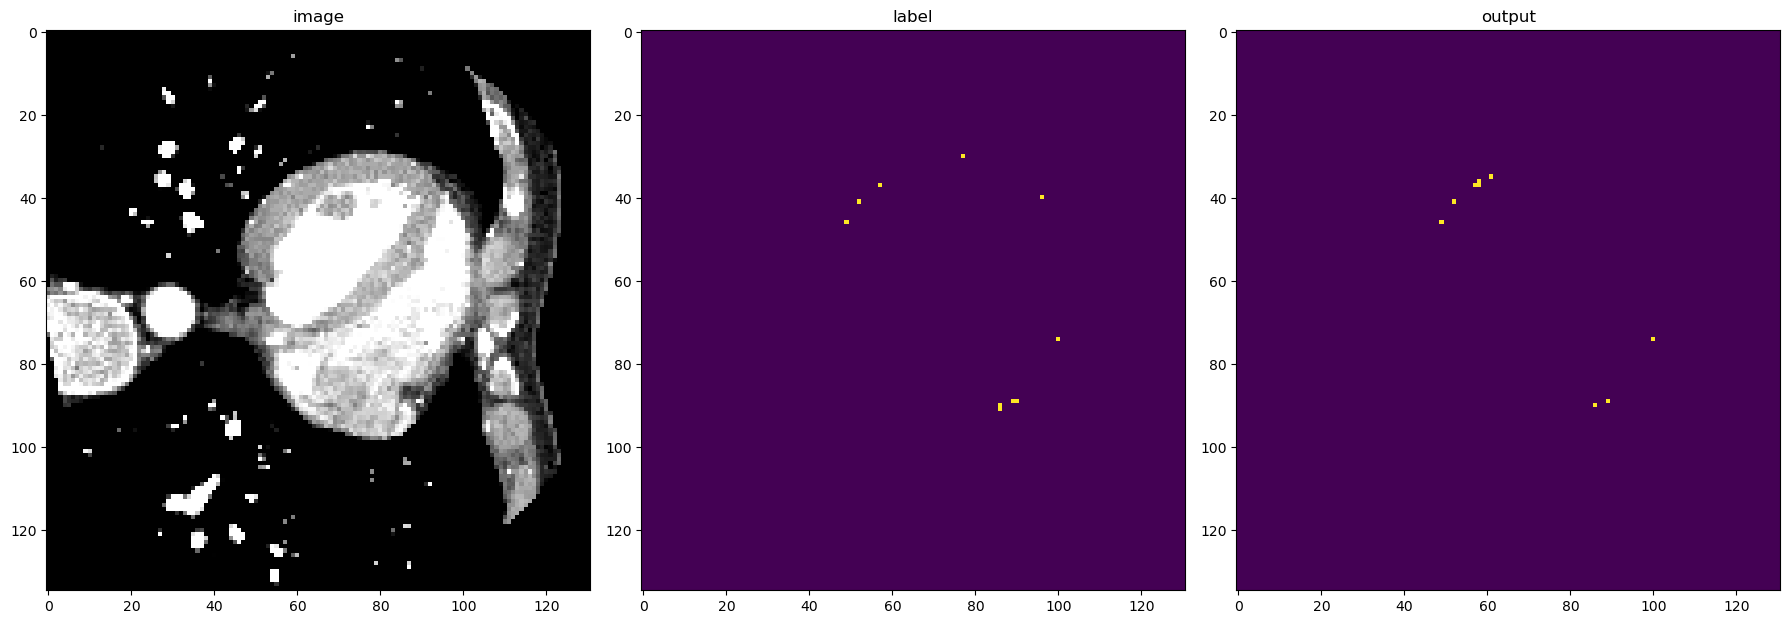

In [18]:
case_num = 0
model.load_state_dict(torch.load(os.path.join(root_dir, "SegResNet.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    # Adjust layout to prevent overlapping titles
    plt.tight_layout()

    # Save the plot
    plt.savefig('plot2_25k.png')  

    plt.show()

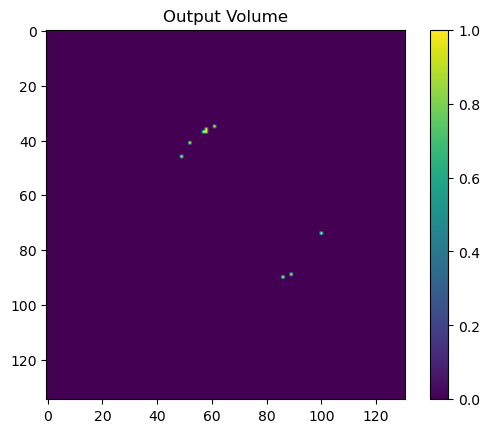

In [19]:

case_num = 0
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)

    # Stack slices along the specified dimension
    output_volume = torch.argmax(val_outputs, dim=1).detach().cpu()

    # Save the 3D volume as an image
    output_volume_np = output_volume.numpy()
    output_volume_np = np.moveaxis(output_volume_np, 0, -1)  # Move channel dimension to the last
    output_volume_np = np.squeeze(output_volume_np)  # Remove singleton channel dimension if present

    # Save the 3D volume as an image file
    output_volume_img = sitk.GetImageFromArray(output_volume_np)
    sitk.WriteImage(output_volume_img, 'output_volume_25k.nii')

    # Plot the first slice for visualization
    plt.imshow(output_volume_np[:, :, slice_map[img_name]])
    plt.title("Output Volume")
    plt.colorbar()
    plt.show()
